# Semantic Segmentation

### Import frameworks, libraries and modules

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
import matplotlib as mpl
from tqdm import tqdm
from scipy import io
import cv2
from glob import glob
from keras import layers
from keras.layers import *

IMAGE_SIZE = 256

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Download and prepare data

### Download images and masks

In [3]:
# ## OS ####
path_mask_folder = os.path.pardir+os.sep+'lib'+os.sep+'MASKS'+os.sep+'*.png'
path_mask_folder

'..\\lib\\MASKS\\*.png'

In [4]:
# ### OS ###
path_images_folder = os.path.pardir+os.sep+'lib'+os.sep+'IMAGES'+os.sep+'*.png'
path_images_folder

'..\\lib\\IMAGES\\*.png'

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
mask_path = [path for path in sorted(glob(path_mask_folder))]
image_path = [path for path in sorted(glob(path_images_folder))]
image_path = image_path[:len(mask_path)]

In [7]:
class DataGenerator():
    'Generates data for Keras'
    
    def __init__(self, path_images, path_mask, img_size, shuffle=True, augmentations=None):
        'Initialization'
        self.path_images = path_images
        self.path_mask = path_mask
        self.img_size = img_size
        self.augment = augmentations
        self.shuffle = shuffle
        self.indexes = np.arange(self.__len__())
        np.random.shuffle(self.indexes)
        
        
        
    def __len__(self):
        return len(self.path_images)

    def __getitem__(self, i):

        if self.augment is None:
            X =  self.X[i]/255
            return X, np.array(self.y[i])
        else:            
                augmented = self.augment(image=self.X[i])
                image = augmented['image']
                image = self.normalize(image)
                mask = self.y[i]                
                return np.array(image), np.array(mask)
     
    def __call__(self):
        
        self.X, self.y = self.data_generation()

        for i in range(self.__len__()):
            
            yield self.__getitem__(i)
            
            if i == self.__len__()-1:
                self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
        
    def normalize(self, x):
        return x/255

    def data_generation(self):

        # Initialization
        X = np.empty((self.__len__(), self.img_size, self.img_size, 3))
        y = np.empty((self.__len__(), self.img_size, self.img_size, 1))

        for i, index in enumerate(self.indexes):
            
            im = cv2.imread(self.path_images[index], 1)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

            mask_path = self.path_mask[index]
            mask = cv2.imread(mask_path, 0)

            # Resize sample
            X[i,] = cv2.resize(im,(self.img_size,self.img_size))
            # Store class
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size))[..., np.newaxis]

        return np.uint8(X),np.uint8(y)

In [8]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform,
    RandomBrightness, RandomBrightnessContrast, GaussNoise,
    OpticalDistortion,RandomSizedCrop
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),

    OneOf([
        RandomContrast(),
        RandomGamma(),
        RandomBrightnessContrast(),
         ], p=0.3),

    OneOf([
        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(),
        ], p=0.3),

    OneOf([
            CLAHE(),
            GaussNoise(),
    ],p=0.6),

    ToFloat(max_value=1)
],p=1)

## Example

In [9]:
Generator = DataGenerator(path_images=image_path[:64], 
                              path_mask=mask_path[:64],
                              augmentations=None, 
                              img_size=IMAGE_SIZE)

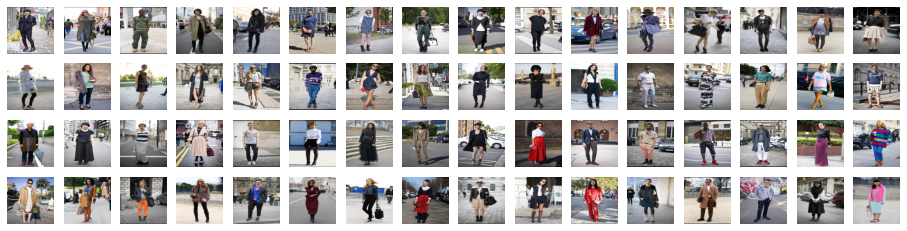

In [10]:
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
x = list(Generator.__call__())
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i in range(max_images):
    im = x[i][0]  
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im);  
    ax.axis('off')

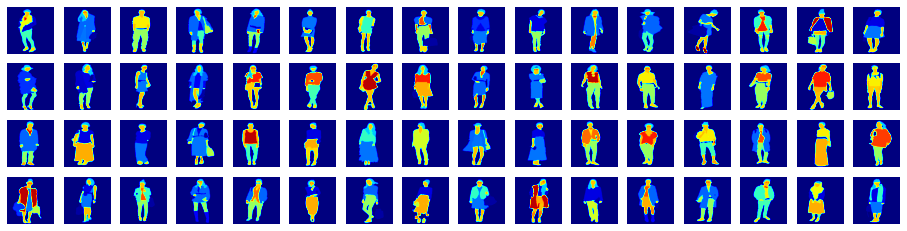

In [11]:
norm = mpl.colors.Normalize(vmin=0, vmax=58)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i in range(max_images):
    mask = x[i][1]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(mask.squeeze(),cmap='jet', norm=norm);   
    ax.axis('off')

Изображения ярлыков имеют 59 сегментированных классов, 
соответствующих таким классам, как волосы, сумка, рубашка, обувь, кожа, 
солнцезащитные очки и кепка.

# Split Data for training and validation

Разделим данные на набор для обучения и проверки в соотношении 80/20.  
Обвернем данные в  объекты TensorFlow Dataset для обучающих и проверочных наборов, чтобы упростить дальнейшую обработку данных.

In [12]:
from sklearn.model_selection import train_test_split
# split data into 80/20 ratio
train_X, val_X,train_y, val_y = train_test_split(image_path, mask_path, test_size=0.2, 
                                                      random_state=0)

In [13]:
training_generator = DataGenerator(path_images=train_X, path_mask=train_y,
                            augmentations=AUGMENTATIONS_TRAIN, img_size=IMAGE_SIZE)

validation_generator = DataGenerator(path_images=val_X, path_mask=val_y,
                              augmentations=None, img_size=IMAGE_SIZE)

In [14]:
train = tf.data.Dataset.from_generator(
     training_generator,
     output_signature=(
         tf.TensorSpec(tf.TensorShape([IMAGE_SIZE, IMAGE_SIZE, 3]), dtype=tf.float32),
         tf.TensorSpec(tf.TensorShape([IMAGE_SIZE, IMAGE_SIZE, 1]), dtype=tf.uint8)))

In [15]:
val = tf.data.Dataset.from_generator(
     validation_generator,
     output_signature=(
         tf.TensorSpec(tf.TensorShape([IMAGE_SIZE, IMAGE_SIZE, 3]), dtype=tf.float32),
         tf.TensorSpec(tf.TensorShape([IMAGE_SIZE, IMAGE_SIZE, 1]), dtype=tf.uint8)))

## Efficient training

In [16]:
BATCH = 16
BUFFER = 800
STEPS_PER_EPOCH = BUFFER//BATCH
VALIDATION_STEPS = 200//BATCH

In [17]:
train = train.cache()
train = train.shuffle(buffer_size = BUFFER, reshuffle_each_iteration=True)
train = train.batch(batch_size = BATCH)
train = train.repeat()
train = train.prefetch(buffer_size=tf.data.AUTOTUNE)

val = val.batch(batch_size = BATCH)

# Build U-Net model 

In [18]:
num_classes = 59
OUTPUT_CHANNELS = 3

In [19]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

In [20]:
def UEfficientNet(input_shape, num_classes, dropout_rate=0.1, trainable=None, ):

    backbone = keras.applications.EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    if not trainable:
        backbone.trainable = False
    else:
        backbone.trainable = True

    input = backbone.input
    start_neurons = 16

    conv5 = backbone.layers[342].output           # (None, 8, 8, 1632)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    pool5 = MaxPooling2D((2, 2))(conv5)
    pool5 = Dropout(dropout_rate)(pool5)
    
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool5)
    convm = residual_block(convm,start_neurons * 32)
    convm = residual_block(convm,start_neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
    
    deconv5 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv5 = concatenate([deconv5, conv5])
    uconv5 = Dropout(dropout_rate)(uconv5)
    
    uconv5 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv5)
    uconv5 = residual_block(uconv5,start_neurons * 16)
    uconv5 = residual_block(uconv5,start_neurons * 16)
    uconv5 = LeakyReLU(alpha=0.1)(uconv5)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv5)
    conv4 = backbone.layers[254].output
    uconv4 = concatenate([deconv4, conv4])    
    uconv4 = Dropout(dropout_rate)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)
    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    conv3 = backbone.layers[107].output
    uconv3 = concatenate([deconv3, conv3])    # (None, 32, 32, 464)  
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = residual_block(uconv3,start_neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    conv2 = backbone.layers[48].output
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.1)(uconv2)

    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = residual_block(uconv2,start_neurons * 4)
    uconv2 = LeakyReLU(alpha=0.1)(uconv2)
    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[19].output
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = residual_block(uconv1,start_neurons * 2)
    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = residual_block(uconv0,start_neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(num_classes, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = keras.Model(input, output_layer, name = 'u-xception')

    model.compile(
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001), 
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
            metrics='accuracy')

    return model

In [21]:
model = UEfficientNet(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), 
                      num_classes=num_classes, 
                      dropout_rate = 0.2, 
                      trainable= False)

In [22]:
# model.summary()

# Training and Fine-tuning

In [23]:
# with tf.device('/GPU:0'):
hist = model.fit(train,
        validation_data=val,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VALIDATION_STEPS,
        epochs=150,
        verbose=2,
        use_multiprocessing=True)

Epoch 1/150
50/50 - 62s - loss: 3.2142 - accuracy: 0.4082 - val_loss: 212.2425 - val_accuracy: 0.7571 - 62s/epoch - 1s/step
Epoch 2/150
50/50 - 24s - loss: 1.9680 - accuracy: 0.7319 - val_loss: 26.2468 - val_accuracy: 0.3512 - 24s/epoch - 489ms/step
Epoch 3/150
50/50 - 23s - loss: 1.3268 - accuracy: 0.7610 - val_loss: 9.3990 - val_accuracy: 0.3512 - 23s/epoch - 455ms/step
Epoch 4/150
50/50 - 23s - loss: 1.0533 - accuracy: 0.7716 - val_loss: 2.5183 - val_accuracy: 0.6683 - 23s/epoch - 452ms/step
Epoch 5/150
50/50 - 22s - loss: 0.9608 - accuracy: 0.7748 - val_loss: 1.9724 - val_accuracy: 0.7037 - 22s/epoch - 447ms/step
Epoch 6/150
50/50 - 23s - loss: 0.9172 - accuracy: 0.7765 - val_loss: 1.4564 - val_accuracy: 0.7310 - 23s/epoch - 451ms/step
Epoch 7/150
50/50 - 23s - loss: 0.8968 - accuracy: 0.7766 - val_loss: 1.4738 - val_accuracy: 0.7066 - 23s/epoch - 454ms/step
Epoch 8/150
50/50 - 23s - loss: 0.8784 - accuracy: 0.7768 - val_loss: 1.5586 - val_accuracy: 0.7139 - 23s/epoch - 451ms/step


50/50 - 23s - loss: 0.7528 - accuracy: 0.7977 - val_loss: 0.7808 - val_accuracy: 0.7923 - 23s/epoch - 459ms/step
Epoch 67/150
50/50 - 23s - loss: 0.7574 - accuracy: 0.7974 - val_loss: 0.7342 - val_accuracy: 0.7990 - 23s/epoch - 458ms/step
Epoch 68/150
50/50 - 23s - loss: 0.7526 - accuracy: 0.7978 - val_loss: 0.7297 - val_accuracy: 0.7984 - 23s/epoch - 459ms/step
Epoch 69/150
50/50 - 23s - loss: 0.7588 - accuracy: 0.7968 - val_loss: 0.7511 - val_accuracy: 0.7957 - 23s/epoch - 458ms/step
Epoch 70/150
50/50 - 23s - loss: 0.7490 - accuracy: 0.7983 - val_loss: 0.7326 - val_accuracy: 0.7996 - 23s/epoch - 459ms/step
Epoch 71/150
50/50 - 24s - loss: 0.7498 - accuracy: 0.7983 - val_loss: 0.7378 - val_accuracy: 0.7991 - 24s/epoch - 471ms/step
Epoch 72/150
50/50 - 23s - loss: 0.7557 - accuracy: 0.7976 - val_loss: 0.7339 - val_accuracy: 0.7985 - 23s/epoch - 457ms/step
Epoch 73/150
50/50 - 23s - loss: 0.7455 - accuracy: 0.7993 - val_loss: 0.7408 - val_accuracy: 0.7966 - 23s/epoch - 458ms/step
Epoch

Epoch 131/150
50/50 - 23s - loss: 0.6597 - accuracy: 0.8204 - val_loss: 0.8118 - val_accuracy: 0.7874 - 23s/epoch - 458ms/step
Epoch 132/150
50/50 - 23s - loss: 0.6563 - accuracy: 0.8230 - val_loss: 0.7602 - val_accuracy: 0.8021 - 23s/epoch - 458ms/step
Epoch 133/150
50/50 - 23s - loss: 0.6591 - accuracy: 0.8214 - val_loss: 0.7609 - val_accuracy: 0.8019 - 23s/epoch - 458ms/step
Epoch 134/150
50/50 - 23s - loss: 0.6494 - accuracy: 0.8236 - val_loss: 0.7815 - val_accuracy: 0.7988 - 23s/epoch - 460ms/step
Epoch 135/150
50/50 - 23s - loss: 0.6458 - accuracy: 0.8246 - val_loss: 0.7697 - val_accuracy: 0.7943 - 23s/epoch - 467ms/step
Epoch 136/150
50/50 - 23s - loss: 0.6571 - accuracy: 0.8230 - val_loss: 0.7661 - val_accuracy: 0.8017 - 23s/epoch - 464ms/step
Epoch 137/150
50/50 - 23s - loss: 0.6443 - accuracy: 0.8244 - val_loss: 0.7816 - val_accuracy: 0.7966 - 23s/epoch - 459ms/step
Epoch 138/150
50/50 - 23s - loss: 0.6519 - accuracy: 0.8228 - val_loss: 0.8026 - val_accuracy: 0.7953 - 23s/epo

### Make some prediction and visualize them to evaluate the model qualitatively.

In [24]:
tf.keras.models.save_model(
    model,
    os.path.join(os.path.pardir+os.sep+'models'+ os.sep,'model_EfficientNet.h5')
)

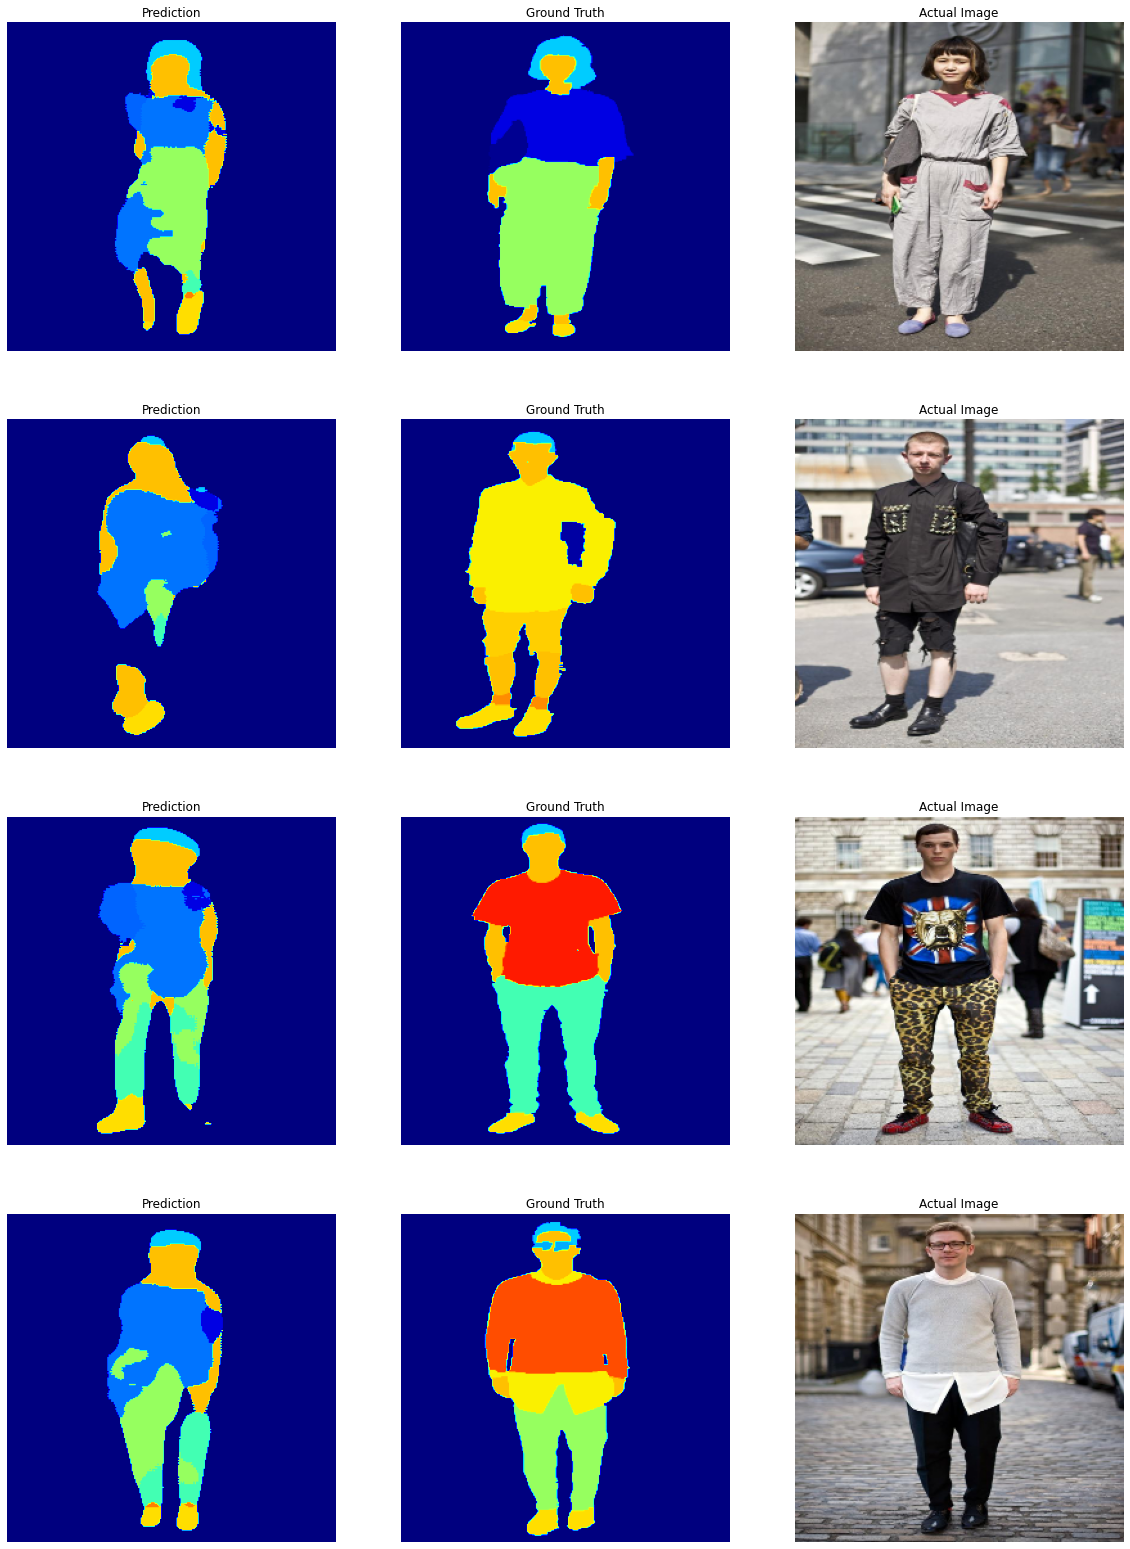

In [25]:
# select a validation data batch
img, mask = next(iter(val))
# make prediction
pred = model.predict(img)
plt.figure(figsize=(20,28))

k = 0
for i in pred:
    # plot the predicted mask
    plt.subplot(4,3,1+k*3)
    i = tf.argmax(i, axis=-1)
    plt.imshow(i,cmap='jet', norm=norm)
    plt.axis('off')
    plt.title('Prediction')

    # plot the groundtruth mask
    plt.subplot(4,3,2+k*3)
    plt.imshow(tf.squeeze(mask[k]), cmap='jet', norm=norm)
    plt.axis('off')
    plt.title('Ground Truth')

    # plot the actual image
    plt.subplot(4,3,3+k*3)
    plt.imshow(img[k])
    plt.axis('off')
    plt.title('Actual Image')
    k += 1
    if k == 4: break
plt.show()

# Performance Curves

### Plot the performance curves to understand how the model learnt on the data 

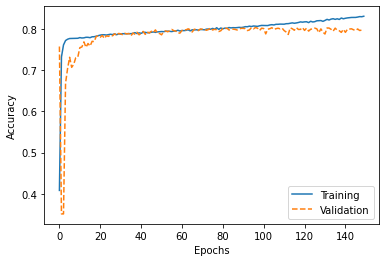

In [26]:
history = hist.history
acc=history['accuracy']
val_acc = history['val_accuracy']

plt.plot(acc, '-', label='Training')
plt.plot(val_acc, '--', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# plt.ylim([0.8,1.0])
plt.legend()
plt.show()